<a target="_blank" href="https://colab.research.google.com/github/PaulLerner/aivancity_nlp/blob/main/pw1_embedding.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Part 0 - Installation and imports

Hit `Ctrl+S` to save a copy of the Colab notebook to your drive

Run on Google Colab GPU:
- Connect
- Modify execution
- GPU

![image.png](https://paullerner.github.io/aivancity_nlp/_static/colab_gpu.png)

In [ ]:
%pip install datasets

In [ ]:
import torch

In [ ]:
assert torch.cuda.is_available(), "Connect to GPU and try again (ask teacher for help)"

# Part 1 - Training Skipgram with negative sampling

(aka word2vec)
Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). [Distributed Representations of Words and Phrases and their Compositionality](https://papers.neurips.cc/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html). Advances in Neural Information Processing Systems, 26.

Eisenstein, J. (2018). [Natural Language Processing](https://csunibo.github.io/natural-language-processing/books/eisenstein-natural-language-processing.pdf) Chapter 14.5

Not to be confused with Softmax Skipgram



## Training data

In [ ]:
from datasets import load_dataset, DatasetDict

texts = load_dataset('wikitext', 'wikitext-103-raw-v1')['train'].shuffle(seed=1111).select(range(10000))["text"]
len(texts)

10000

### Tokenization

Unsing [`re`](https://docs.python.org/3/library/re.html), tokenize the text in a `List[str]` to keep only words, no punctuation or space. We will also preprocess the text to make it lowercase, so our model is *case-insensitive*

If you don't know anything about regex, a good place to start is https://regex101.com/

In [ ]:
import re

In [ ]:
texts[0]

" Following the death of Finan , bishop of Lindisfarne , Alhfrith of Deira , in collusion with Wilfred of York , Agilbert of Wessex and others , were determined to persuade Oswiu to rule in favour of the Roman rite of Christianity within the kingdoms over which he had imperium . The case was debated in Oswiu 's presence at the Synod of Whitby in 664 , with Colmán , Hild and Cedd defending the Celtic rite and the tradition inherited from Aidan , and Wilifred speaking for the Roman position . The Roman cause prevailed and the former division of ecclesiastical authorities was set aside . Those who could not accept it , including Colmán , departed elsewhere . \n"

In [ ]:
# expected results

['following',
 'the',
 'death',
 'of',
 'finan',
 'bishop',
 'of',
 'lindisfarne',
 'alhfrith',
 'of',
 'deira',
 'in',
 'collusion',
 'with',
 'wilfred',
 'of',
 'york',
 'agilbert',
 'of',
 'wessex',
 'and',
 'others',
 'were',
 'determined',
 'to',
 'persuade',
 'oswiu',
 'to',
 'rule',
 'in',
 'favour',
 'of',
 'the',
 'roman',
 'rite',
 'of',
 'christianity',
 'within',
 'the',
 'kingdoms',
 'over',
 'which',
 'he',
 'had',
 'imperium',
 'the',
 'case',
 'was',
 'debated',
 'in',
 'oswiu',
 's',
 'presence',
 'at',
 'the',
 'synod',
 'of',
 'whitby',
 'in',
 '664',
 'with',
 'colmán',
 'hild',
 'and',
 'cedd',
 'defending',
 'the',
 'celtic',
 'rite',
 'and',
 'the',
 'tradition',
 'inherited',
 'from',
 'aidan',
 'and',
 'wilifred',
 'speaking',
 'for',
 'the',
 'roman',
 'position',
 'the',
 'roman',
 'cause',
 'prevailed',
 'and',
 'the',
 'former',
 'division',
 'of',
 'ecclesiastical',
 'authorities',
 'was',
 'set',
 'aside',
 'those',
 'who',
 'could',
 'not',
 'accept',
 '

### Vocabulary



Using `collections.Counter`, construct the vocabulary by tokenizing every text in the dataset and keeping only the $V$ most frequent words. Let's set $V=1000$ to start

Then use this vocabulary to vectorize examples, assigning integer identifiers to words (from $0$ to $V-1$)

In [ ]:
from collections import Counter
V = 1000

In [ ]:
# expected results
occurrences.most_common(10)

[('the', 35377),
 ('of', 14994),
 ('and', 13832),
 ('in', 12074),
 ('to', 11022),
 ('a', 9897),
 ('was', 5883),
 ('on', 4257),
 ('s', 4221),
 ('as', 3989)]

In [ ]:
# expected results
len(occurrences)

39030

In [ ]:
# integer indentifiers of the above example: texts[0]

[120,
 0,
 251,
 1,
 1,
 1,
 3,
 11,
 1,
 235,
 1,
 2,
 509,
 20,
 4,
 4,
 3,
 1,
 0,
 1,
 241,
 0,
 56,
 23,
 15,
 22,
 0,
 537,
 6,
 3,
 8,
 17,
 0,
 1,
 3,
 11,
 2,
 0,
 2,
 0,
 19,
 2,
 10,
 0,
 457,
 0,
 2,
 0,
 299,
 278,
 1,
 6,
 248,
 236,
 39,
 145,
 29,
 18,
 106]

### Self-supervision: input and targets from raw text

using `window_size=2`, iterate through the tokenized data and collect indices of target word $w$ and positive context words $c_+$

After debugging, apply this function to all text in dataset

In [ ]:
word_contexts = []
window_size=2

In [ ]:
word_contexts[:10]

[(251, 120),
 (251, 0),
 (251, 1),
 (251, 1),
 (1, 0),
 (1, 251),
 (1, 1),
 (1, 1),
 (1, 251),
 (1, 1)]

In [ ]:
len(word_contexts)

1155856

### DataLoader

`torch.utils.data.DataLoader` provides a convenient interface for batching and randomly sampling data.

use `batch_size=1024` to wrap the above generate data

and `drop_last=True` so that the batch has always the same size


In [ ]:
batch_size = 1024

In [ ]:
loader = torch.utils.data.DataLoader(word_contexts, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
for words, contexts in loader:
    break

In [ ]:
words

tensor([ 24, 381,   4,  ...,   1,   8,   1])

In [ ]:
words.shape, contexts.shape

(torch.Size([1024]), torch.Size([1024]))

In [ ]:
contexts.shape

torch.Size([64, 11])

### Negative examples

Using `torch.randint` draw $k=10$ random negative examples from the vocabulary for each target word $w$


In [ ]:

k=10

In [ ]:
negatives.shape

torch.Size([1024, 10])

Concatenate the indices of negatives and positives examples but keep track of the labels (`1.0` for positive, `0.0` for negative)

In [ ]:
labels.shape

torch.Size([1024, 11])

In [ ]:
contexts.shape

torch.Size([1024, 11])

## Model


![diagram](https://paullerner.github.io/aivancity_nlp/_static/skipgram.png)

Using `nn.Embedding`, initialize the two word embedding matrices, $W$ (word) and $C$ (context), of shape $(V, d)$. Let's see $d=100$ for now.

In [ ]:
d=100

In [ ]:
import torch.nn as nn

In [ ]:
W.weight.shape

torch.Size([1000, 100])

You can then call these embeddings by passing them the tokens indices computed above to get the vectors

In [ ]:
W(words).shape

torch.Size([64, 100])

In [ ]:
C(contexts).shape

torch.Size([64, 11, 100])

## Probability of similarity (sigmoid)
$$P(+ | w,c) = \sigma(c \cdot w) = \frac{1}{1+\exp(-c \cdot w)}$$


Compute the similarity $c \cdot w$. No need to compute Sigmoid as it is integrated in the loss function (see below).

In [ ]:
similarities.shape

torch.Size([64, 11])



## Loss: Binary Cross Entropy

Compute the loss using `nn.BCEWithLogitsLoss`

$$- \left(\log\sigma(c_+ \cdot w) + \sum_{i=1}^{k} \log\sigma(-c_i \cdot w)\right) $$

You will need to reshape similarities and labels

In [ ]:
similarities.reshape(-1).shape

torch.Size([704])

tensor(3.9763, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Training loop

Now that you checked everything is working, pack everything above in a `nn.Module` and training loop

Ensure that everything is on GPU by calling `.cuda()` or passing `device="cuda"` on init

In [ ]:
class Skipgram(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO
        self.W =
        self.C =

    def forward(self, words, contexts):
        # TODO
        return similarities

In [ ]:
%load_ext tensorboard

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

Run tensorboard before training. Refresh during training.

In [ ]:
%tensorboard --logdir logs

In [ ]:
skipgram = Skipgram().cuda()

optimizer = torch.optim.AdamW(skipgram.parameters(), lr=0.0001)

batch_size = 1024
k=10
loader = torch.utils.data.DataLoader(word_contexts, batch_size=batch_size, shuffle=True, drop_last=True)

steps = 0
for epoch in range(10):
    for words, contexts in loader:
        words = words.cuda()
        contexts = contexts.cuda()

        # TODO
        negatives =

        similarities =

        loss = loss_fct(similarities.reshape(-1), labels.reshape(-1))
        writer.add_scalar("Loss/train", loss.item(), steps)
        steps+=1
        loss.backward()
        optimizer.step()


# Part 2 - Analogies and Intrinsic Evaluation of Embeddings

## Data and imports

We'll manipulate numpy arrays instead of torch tensors from here

In [ ]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 68.3 MB/s eta 0:00:000m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import numpy as np

In [ ]:
import gensim.downloader

In [ ]:
# take the embeddings from the model you just trained
#embeddings = skipgram.W.weight.detach().cpu().numpy()

In [ ]:
# load from a model you previously trained
#embeddings = torch.load("embeddings.bin").numpy()

In [ ]:
# load a model someone else trained, probably better than yours (more data, larger vocabulary, etc.)
keyedvectors = gensim.downloader.load("word2vec-google-news-300")

embeddings = keyedvectors.vectors
vocabulary = {word: index for index, word in enumerate(keyedvectors.index_to_key)}
i2token = {index: word for index, word in enumerate(keyedvectors.index_to_key)}
V = len(vocabulary)

## Qualitative/playing around

### visualization

We'll reduce embeddings to 2D using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) to be able to plot them

What can you see from the plot? Take a look at near-synonyms like "large" and "massive", or "interesting" and "fascinating".

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)


Using `plt.scatter` plot the 2D embeddings of the words in `words`. Also show the word using `plt.annotate`

In [ ]:
words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge', "woman","man","he","she",'july',
 'december',
 'february',
 'november',
 'october',
 'january',
 'april',
 'june']


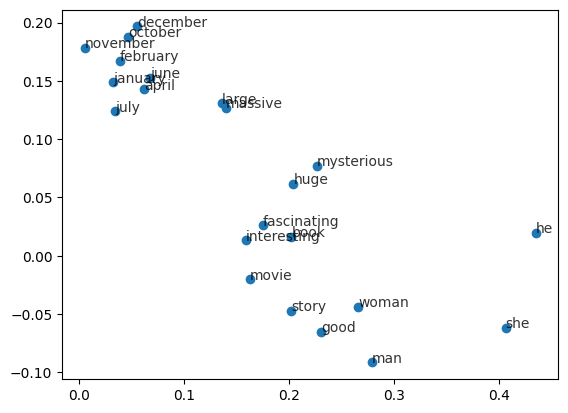

### Nearest neighbors


Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:



Instead of computing the actual angle, we can leave the similarity in terms of similarity $s = \cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| \cdot ||q||}, \textrm{ where } s \in [-1, 1] $$


Compute the 10 nearest neighbors of the words from the above `words` list

['movie', 'film', 'movies', 'films', 'moive', 'Movie', 'horror_flick', 'sequel', 'Guy_Ritchie_Revolver', 'romantic_comedy']
['book', 'tome', 'books', 'memoir', 'paperback_edition', 'autobiography', 'memoirs', 'Book', 'paperback', 'novels']
['mysterious', 'Mysterious', 'enigmatic', 'mystery', 'sinister', 'mystical', 'strange', 'shadowy', 'ghostly', 'unexplained']
['story', 'stories', 'tale', 'Associated_PressComment', 'fable', 'tales', 'retelling', 'narrative', 'Story', 'backstory']
['fascinating', 'interesting', 'intriguing', 'enlightening', 'captivating', 'facinating', 'riveting', 'instructive', 'endlessly_fascinating', 'revelatory']
['good', 'great', 'bad', 'terrific', 'decent', 'nice', 'excellent', 'fantastic', 'better', 'solid']
['interesting', 'intriguing', 'fascinating', 'exciting', 'Interesting', 'intersting', 'instructive', 'intruiging', 'amusing', 'enlightening']
['large', 'sizeable', 'small', 'sizable', 'Large', 'huge', 'larger', 'massive', 'smaller', 'substantial']
['massive

#### Bias

What word appears in the top-10 closest to "woman" and "she"? Compare to "man" and "he".

### Analogies

#### Semantic analogies
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : grandfather :: woman : t" (read: man is to grandfather as woman is to t), what is t?

noting analogies $x:y :: z:t$ ($x$ is to $y$ as $z$ is to?) solve the following analogies using:
$$\max_{t\in V} \cos(t, y-x+z)$$

You'll see that it does not work perfectly. Instead of keep only the very $\max_{t\in V}$, keep the top 5 (like in the nearest neighbors above)

What's the difference between the first analogies `[("France", "Paris", "Germany"), ("France", "Sarkozy", "Germany")]` and the others?

Try your own examples

In [ ]:
for x, y, z in [("France", "Paris", "Germany"), ("France", "Sarkozy", "Germany"), ("France", "French", "Germany"), ("dog","puppy","cat"), ("man", "grandfather", "woman"), ("man", "king", "woman"), ("apple", "tree", "grape")]:
    raise NotImplementedError("TODO")

France:Paris :: Germany:['Berlin', 'Frankfurt', 'Dusseldorf', 'Paris', 'Munich']
France:Sarkozy :: Germany:['Sarkozy', 'Merkel', 'Chancellor_Angela_Merkel', 'Schröder', 'Chirac']
France:French :: Germany:['German', 'Germany', 'Austrian', 'Dutch', 'Germans']
dog:puppy :: cat:['cat', 'puppy', 'kitten', 'puppies', 'pup']
man:grandfather :: woman:['grandfather', 'grandmother', 'granddaughter', 'mother', 'aunt']
man:king :: woman:['king', 'queen', 'monarch', 'princess', 'crown_prince']
apple:tree :: grape:['tree', 'grape', 'trees', 'vines', 'vine']


#### Biases

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Using the same code as above, notice how "gynecologist" is top-2 of "man is to doctor as woman is to?" and "nurse" is 3

Why is that? Try to find other problematic analogies/biases in the embeddings

In [ ]:
for x, y, z in [("man", "doctor", "woman")]:

man:doctor :: woman:['doctor', 'gynecologist', 'nurse', 'physician', 'doctors']


### Syntactic analogies

Word embeddings capture both semantic and syntactic analogies! Use the same code as above but for the following word list.

Notice how it works even with irregular verbs like "eat"


Try your own examples

In [ ]:
for x, y, z in [
    # derivational morphology: suffixation
    ("speak", "speaker", "sing"),
    ("short", "shortly", "rapid"),
    # derivational morphology: prefixation
    ("like", "unlike", "able"),
    # inflectional morphology: verbs
    ("walking", "walked", "work"),
    ("walking", "walked", "eating"),
    ("walking", "walked", "going"),
    # inflectional morphology: nouns
    ("shoe", "shoes", "table"),
]:

speak:speaker :: sing:['speaker', 'sing', 'singing', 'sang', 'singers']
short:shortly :: rapid:['shortly', 'rapid', 'Shortly', 'rapidly', 'Immediately']
like:unlike :: able:['able', 'unable', 'unlike', 'managed', 'allowed']
walking:walked :: work:['work', 'worked', 'walked', 'hustled', 'went']
walking:walked :: eating:['ate', 'eating', 'eat', 'eaten', 'wolfing_down']
walking:walked :: going:['going', 'went', 'got', 'walked', 'came']
shoe:shoes :: table:['table', 'tables', 'Tables', 'ConocoPhillips_BPAmerica', 'linen_napkins']


## Quantitative evaluation using academic benchmarks

### Correlation of similarity with human judgements

#### data

In [ ]:
!wget https://staff.fnwi.uva.nl/e.bruni/resources/MEN.zip

--2024-09-13 15:13:10--  https://staff.fnwi.uva.nl/e.bruni/resources/MEN.zip
Resolving staff.fnwi.uva.nl (staff.fnwi.uva.nl)... 146.50.97.212
Connecting to staff.fnwi.uva.nl (staff.fnwi.uva.nl)|146.50.97.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96854 (95K) [application/zip]
Saving to: 'MEN.zip'

MEN.zip             100%[===================>]  94.58K  --.-KB/s    in 0.04s   

2024-09-13 15:13:10 (2.25 MB/s) - 'MEN.zip' saved [96854/96854]



In [ ]:
!unzip MEN

Archive:  MEN.zip
   creating: MEN/
  inflating: MEN/licence.txt         
  inflating: MEN/.DS_Store           
   creating: MEN/agreement/
  inflating: MEN/agreement/elias-men-ratings.txt  
  inflating: MEN/agreement/agreement-score.txt  
  inflating: MEN/agreement/marcos-men-ratings.txt  
  inflating: MEN/instructions.txt    
  inflating: MEN/MEN_dataset_lemma_form.test  
  inflating: MEN/MEN_dataset_lemma_form.dev  
  inflating: MEN/MEN_dataset_lemma_form_full  
  inflating: MEN/MEN_dataset_natural_form_full  


In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv("MEN/MEN_dataset_natural_form_full", delimiter=" ",names=["a","b","label"])

In [ ]:
dataset

,a,b,label
0,sun,sunlight,50.0
1,automobile,car,50.0
2,river,water,49.0
3,stairs,staircase,49.0
4,morning,sunrise,49.0
...,...,...,...
2995,feathers,truck,1.0
2996,festival,whiskers,1.0
2997,muscle,tulip,1.0
2998,bikini,pizza,1.0


#### evaluation

Compute the cosine similarity of words `a` and `b` for all words in the dataset, except (of course), those that are absent from our `vocabulary`.

Compute Spearmann correlation between the cosine similarity you computed and the label, using `scipy.stats.spearmanr`

In [ ]:
import scipy

SignificanceResult(statistic=0.7819958890602363, pvalue=0.0)

Compare this value to what is reported in Levy, O., & Goldberg, Y. (2014). Neural Word Embedding as Implicit Matrix Factorization. Advances in Neural Information Processing Systems, 27. https://proceedings.neurips.cc/paper/2014/hash/feab05aa91085b7a8012516bc3533958-Abstract.html


Inspect this correlation visually: plot the cosine similarities against the labels

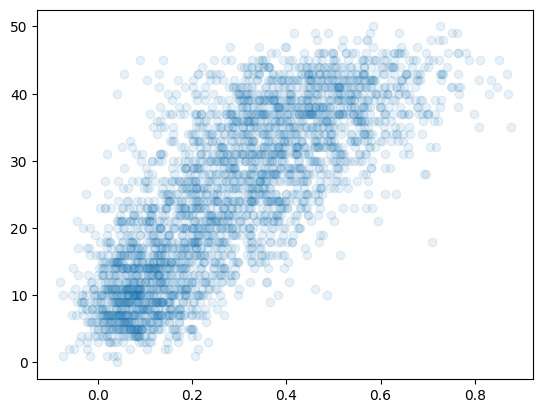

### Accuracy of analogies

#### Data

In [ ]:
!wget https://www.fit.vut.cz/person/imikolov/public/rnnlm/word-test.v1.txt

--2024-09-13 15:34:35--  https://www.fit.vut.cz/person/imikolov/public/rnnlm/word-test.v1.txt
Resolving www.fit.vut.cz (www.fit.vut.cz)... 147.229.9.65, 2001:67c:1220:809::93e5:941
Connecting to www.fit.vut.cz (www.fit.vut.cz)|147.229.9.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609126 (595K) [text/plain]
Saving to: 'word-test.v1.txt'

word-test.v1.txt    100%[===================>] 594.85K  2.58MB/s    in 0.2s    

2024-09-13 15:34:35 (2.58 MB/s) - 'word-test.v1.txt' saved [609126/609126]



In [ ]:
with open("word-test.v1.txt","rt") as file:
    lines = file.read().strip().split("\n")

In [ ]:
lines.pop(0)

'// Copyright 2013 Google Inc. All Rights Reserved.'

In [ ]:
dataset = []
subset_ok=False
for i, line in enumerate(lines):
    # We keep a single subset to save computation time.
    # As a bonus, compute the results on the entire dataset, or for each subset
    if line[0]==":":
        if line ==": family":
            subset_ok=True
        if line == ": gram1-adjective-to-adverb":
            break
        continue
    if subset_ok:
        x,y,z,t = line.split(" ")
        ok = True
        for token in [x,y,z,t]:
            if token not in vocabulary:
                ok = False
                break
        if ok:
            dataset.append((x,y,z,t))

In [ ]:
len(dataset)

506

In [ ]:
for i in np.random.choice(len(dataset), 10):
    x, y, z, t = dataset[i]
    print(f"{x}:{y} :: {z}:{t}")

stepfather:stepmother :: father:mother
brothers:sisters :: prince:princess
stepson:stepdaughter :: stepfather:stepmother
nephew:niece :: he:she
sons:daughters :: uncle:aunt
king:queen :: uncle:aunt
sons:daughters :: nephew:niece
dad:mom :: policeman:policewoman
father:mother :: grandson:granddaughter
grandson:granddaughter :: sons:daughters


#### evaluation

Using the same code as above, solve the analogy for $x:y :: z:t$ ($x$ is to $y$ as $z$ is to?) using:
$$\max_{t\in V} \cos(t, y-x+z)$$

For all samples of the dataset

Compute the accuracy (check that you retrieve the correct $t$)

In [ ]:
accuracy

0.34980237154150196

Compare this value to what is reported in Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space (arXiv:1301.3781). arXiv. https://doi.org/10.48550/arXiv.1301.3781

Remember we used only the "family" subset, not all semantic analogies.


# Bonus Part

- Try different hyperparameters in Part. 1:
  - Vocabulary size $V$
  - `window_size`
  - Number of negative examples $k$
  - embedding dimension $d$

- Try other models than Skipgram in Part. 2:
  - [fastText](https://fasttext.cc/docs/en/english-vectors.html)
  - [GloVe](https://nlp.stanford.edu/projects/glove/) (also available via `gensim` used above)
  - CBOW